In [1]:
import chess
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

import string
import ast

from tqdm import tqdm

from icecream import ic

import time

import random

import wandb

In [2]:
!wandb login

wandb: Currently logged in as: lino-giger (solo_chess_project). Use `wandb login --relogin` to force relogin


In [3]:
df = pd.read_csv("chess_games.csv")

In [4]:
df['chess_moves_list'] = df['chess_moves_list'].apply(ast.literal_eval)

In [5]:
df.head()

,Result,chess_moves_list
0,Black Wins,"[e4, e6, d4, d5, Nc3, Nf6, exd5, exd5, Nf3, Be..."
1,Black Wins,"[e4, e5, Nf3, Nc6, Bb5, Nf6, O-O, Nxe4, d4, Be..."
2,White Wins,"[d4, d5, c4, e6, Nc3, Nf6, Bg5, Be7, e3, c6, c..."
3,White Wins,"[e4, e5, Nc3, Nf6, Bc4, Bc5, d3, d6, f4, Ng4, ..."
4,Black Wins,"[e4, e5, Nf3, Nf6, Nc3, Bb4, Bc4, O-O, Qe2, d6..."


In [6]:
SYMBOL_TO_INDEX = {
    'P': 0,
    'N': 1,
    'B': 2,
    'R': 3,
    'Q': 4,
    'K': 5,
    'p': 6,
    'n': 7,
    'b': 8,
    'r': 9,
    'q': 10,
    'k': 11,
    '.': 12
}

SCORE_TENSOR = torch.tensor([1, 0, -1]).type(torch.float32).to("cuda")

WHITE_VICOTORY = torch.tensor([1, 0, 0]).type(torch.float32).to("cuda")
BLACK_VICTORY = torch.tensor([0, 0, 1]).type(torch.float32).to("cuda")
DRAW = torch.tensor([0, 1, 0]).type(torch.float32).to("cuda")

TIME_IT = False

board = chess.Board()

class FFN(nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(64*13+1, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, 64*13+1)  # Reshape the input to match the first layer's expected input size
        x = self.fc_layers(x)
        return x

# Create an instance of the FFN model
model = FFN()
model = model.to('cuda')


In [7]:
model(torch.randn(500, 64*13+1).to('cuda'))

tensor([[0.3495, 0.3302, 0.3203],
        [0.3497, 0.3298, 0.3205],
        [0.3482, 0.3333, 0.3185],
        ...,
        [0.3497, 0.3312, 0.3191],
        [0.3503, 0.3277, 0.3220],
        [0.3474, 0.3294, 0.3232]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [8]:
def time_it(func, name, *args, **kwargs):
    global TIME_IT
    if not TIME_IT:
        return func(*args, **kwargs)
    start = time.time()
    result = func(*args, **kwargs)
    print(f"Time taken by {name}: {time.time() - start} seconds")
    return result

def boards2tensor(boards):
    # Pre-allocate the tensor for all boards
    all_boards = []

    for board in boards:
        # Convert the board to index values using the SYMBOL_TO_INDEX mapping
        board_indexes = [SYMBOL_TO_INDEX[symbol] for symbol in str(board).replace('\n', ' ').split(' ')]
        
        # One-hot encode the board
        one_hot_board = F.one_hot(torch.tensor(board_indexes), num_classes=len(SYMBOL_TO_INDEX)).view(-1)
        
        turn_info = torch.tensor([1.0 if board.turn == chess.WHITE else -1.0], dtype=torch.float32)
        board_tensor = torch.cat((turn_info, one_hot_board))
        
        # Add to the list
        all_boards.append(board_tensor)

    # Stack all boards into a batch tensor and move to GPU
    batched_tensor = torch.stack(all_boards).type(torch.float32).cuda()

    return batched_tensor

def calculate_scores(model, batched_boards):
    return (model(batched_boards) * SCORE_TENSOR).sum(dim=1)

def board_score(model, boards):
    with torch.no_grad():
        batched_boards = time_it(boards2tensor, " boards2tensor", boards) 
        scores = time_it(calculate_scores, "calculate_scores", model, batched_boards)
        return scores 
    
def find_best_moves(model, boards, epsilon=0.1):
    all_legal_moves = []
    all_boards_after_move = []
    for board in boards:
        legal_moves = list(board.legal_moves)
        all_legal_moves.append((legal_moves, board.turn))
        boards_after_move = []
        for move in legal_moves:
            board.push(move)
            boards_after_move.append(board.copy())
            board.pop()
        all_boards_after_move.extend(boards_after_move)
    # Get scores for all boards in one batch
    
    move_scores = board_score(model, all_boards_after_move)
    
    best_moves = []
    start_idx = 0
    
    for legal_moves, turn_info in all_legal_moves:
        if len(legal_moves) == 0:
            best_moves.append(None)  # Or handle appropriately
            continue

        end_idx = start_idx + len(legal_moves)

        # Epsilon-greedy strategy
        if random.random() < epsilon:
            # Choose a random move
            best_move = random.choice(legal_moves).uci()
        else:
            if turn_info == chess.WHITE:
                best_move = legal_moves[move_scores[start_idx:end_idx].argmax()].uci()
            else:
                best_move = legal_moves[move_scores[start_idx:end_idx].argmin()].uci()
                
        best_moves.append(best_move)
        start_idx = end_idx

    return best_moves

In [20]:
model(boards2tensor([chess.Board()]))[0]

tensor([0.3340, 0.3520, 0.3140], device='cuda:0', grad_fn=<SelectBackward0>)

In [9]:
learning_rate = 0.0001
num_games=10_000
epochs = 1

wandb.init(
    # set the wandb project where this run will be logged
    project="solo_chess_project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "num_games": num_games,
    "epochs": epochs,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: lino-giger (solo_chess_project). Use `wandb login --relogin` to force relogin


In [10]:

def result_to_tensor(result):
    if result == "White Wins":
        return WHITE_VICOTORY
    elif result == "Black Wins":
        return BLACK_VICTORY
    else:
        return DRAW

def train_model(model, num_games, learning_rate, games, epochs=1):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    board = chess.Board()
    losses = []
    
    for epoch in range(epochs):  # Outer loop for epochs
        print(f"Epoch {epoch+1}/{epochs}")
        cumulative_loss = 0
        games_processed = 0
        epoch_losses = []
        
        # Sample games for each epoch to introduce variability
        randomly_selected_games = games.sample(n=num_games, random_state=1) 
        
        for game_idx, game in enumerate(tqdm(randomly_selected_games.iterrows(), total=num_games)):
            loss = 0
            game_length = len(game[1]["chess_moves_list"])
            result_tensor = result_to_tensor(game[1]["Result"])
            board.reset()
            for move in game[1]["chess_moves_list"]:
                try:
                    board.push_san(move)
                except:
                    print(f"Invalid move: {move} at game {game[0]}")
                    break
                model_output = model(boards2tensor([board]))
                wandb.log({"Draw Prob": model_output[0][1].item(), 
                           "White Win Prob": model_output[0][0].item(), 
                           "Black Win Prob": model_output[0][2].item()})
                loss += F.cross_entropy(model_output, result_tensor.unsqueeze(0))
            else:  # This else belongs to the for loop, executed if the loop is not broken
                loss /= game_length
                wandb.log({"loss": loss.item()})
                cumulative_loss += loss.item()
                epoch_losses.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Log average loss every 100 games within an epoch
            games_processed += 1
            if (game_idx + 1) % 100 == 0:
                avg_loss = cumulative_loss / games_processed
                wandb.log({"Average loss every 100 games": avg_loss})
                cumulative_loss = 0
                games_processed = 0
                
        epoch_avg_loss = sum(epoch_losses) / len(epoch_losses) if epoch_losses else 0
        wandb.log({"Average loss for epoch": epoch_avg_loss})
        print(f"Average loss for epoch {epoch+1}: {epoch_avg_loss}")
        losses.append(epoch_avg_loss)
    
    overall_avg_loss = sum(losses) / len(losses) if losses else 0
    print(f"Overall average loss after {epochs} epochs: {overall_avg_loss}")
    

# Example usage
train_model(model, num_games, 0.0001, games=df, epochs=5)


Epoch 1/5


 10%|█         | 1030/10000 [04:31<38:27,  3.89it/s] 

Invalid move: e.p. at game 956117


 18%|█▊        | 1770/10000 [07:47<34:32,  3.97it/s]  

Invalid move: (69. at game 415546


 20%|██        | 2009/10000 [08:53<35:18,  3.77it/s]  

Invalid move: Rf1+ at game 683832


 41%|████▏     | 4130/10000 [17:55<18:17,  5.35it/s]  

Invalid move: Ke4+ at game 844159


 47%|████▋     | 4718/10000 [20:08<18:16,  4.82it/s]

Invalid move: $1 at game 652785


 48%|████▊     | 4835/10000 [20:32<18:30,  4.65it/s]

Invalid move: Kg4 at game 373256


 59%|█████▉    | 5885/10000 [24:36<12:19,  5.56it/s]  

Invalid move: (...) at game 804196


 71%|███████   | 7080/10000 [30:04<11:17,  4.31it/s]

Invalid move: $6 at game 434852


 75%|███████▌  | 7533/10000 [32:02<09:52,  4.17it/s]

Invalid move: ( at game 331968


 85%|████████▌ | 8518/10000 [36:16<04:24,  5.61it/s]

Invalid move: (36. at game 514455


 86%|████████▌ | 8579/10000 [36:30<04:51,  4.88it/s]

Invalid move: $2 at game 894985


 91%|█████████ | 9117/10000 [38:56<03:42,  3.97it/s]

Invalid move: Rfa1 at game 314838


 94%|█████████▎| 9364/10000 [40:06<02:13,  4.76it/s]

Invalid move: . at game 725451


 97%|█████████▋| 9665/10000 [41:29<01:06,  5.00it/s]

Invalid move: $1 at game 492884


100%|██████████| 10000/10000 [43:01<00:00,  3.87it/s]


Average loss for epoch 1: 1.0824060713972665
Epoch 2/5


  0%|          | 17/10000 [00:05<54:19,  3.06it/s]  


KeyboardInterrupt: 

In [11]:
#save model
torch.save(model.state_dict(), "model_trained_10k_games.pth")

In [26]:
display(df.loc[956117])

Result                                                     Black Wins
chess_moves_list    [c4, Nf6, Nc3, e5, Nf3, Nc6, g3, d5, cxd5, Nxd...
Name: 956117, dtype: object

In [29]:
board.reset()

In [11]:
board.push_san("Nf3")

Move.from_uci('g1f3')

In [21]:
def play_a_game():
    counter = 0
    while not board.is_game_over():
        counter += 1
        print(counter, end='\r')
        move = find_best_moves(model, [board])
        if move is None or counter > 1000:
            break
        board.push_uci(move)
    return board.result(), counter

In [22]:
play_a_game()

InvalidMoveError: expected uci string to be of length 4 or 5: ['f2f3']

In [12]:
ic.disable()

In [13]:
def get_reward(board):
    result = board.result()
    if result == '1-0':
        return WHITE_VICOTORY
    elif result == '0-1':
        return BLACK_VICTORY   
    else:
        return DRAW 

def train_model(model, num_games, learning_rate, num_parallel_games):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    boards = [chess.Board() for _ in range(num_parallel_games)]
    game_memories = [[] for _ in range(num_parallel_games)]
    losses = []

    for _ in tqdm(range(num_games)):
        while not all(board.is_game_over() for board in boards):
            best_moves = find_best_moves(model, boards)
            for i, move in enumerate(best_moves):
                if not boards[i].is_game_over():
                    boards[i].push_uci(move)
                    game_memories[i].append(boards2tensor([boards[i]]))

        loss = 0
        game_lengths = [len(game_memory) for game_memory in game_memories]
        for i, board in enumerate(boards):
            target_tensor = get_reward(board)
            board.reset()
            for board_state in game_memories[i]:
                model_output = model(board_state)
                loss += F.cross_entropy(model_output, target_tensor.unsqueeze(0))
            loss /= len(game_memories[i])
            game_memories[i].clear()

        losses.append(loss.item())
        print(f"Loss: {loss.item()}, game lengths: {game_lengths}, outcome: {target_tensor}, predicted: {model_output}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Average loss: {sum(losses)/len(losses)}")

# Example usage
train_model(model, num_games=100, learning_rate=0.001, num_parallel_games=1)


  1%|          | 1/100 [00:01<03:17,  1.99s/it]

Loss: 1.3486417531967163, game lengths: [126], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[0.0012, 0.0207, 0.9780]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  2%|▏         | 2/100 [00:03<03:08,  1.93s/it]

Loss: 1.1736881732940674, game lengths: [138], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[0.3871, 0.4335, 0.1794]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  3%|▎         | 3/100 [00:05<02:41,  1.67s/it]

Loss: 1.0156605243682861, game lengths: [104], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[0.0796, 0.2895, 0.6308]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  4%|▍         | 4/100 [00:08<03:59,  2.49s/it]

Loss: 1.394389271736145, game lengths: [100], outcome: tensor([0., 0., 1.], device='cuda:0'), predicted: tensor([[0.1827, 0.7947, 0.0226]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  5%|▌         | 5/100 [00:10<03:24,  2.15s/it]

Loss: 0.7815361022949219, game lengths: [119], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[0.2248, 0.7222, 0.0529]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  6%|▌         | 6/100 [00:11<02:51,  1.82s/it]

Loss: 0.6831920742988586, game lengths: [107], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[0.0826, 0.9064, 0.0110]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  7%|▋         | 7/100 [00:14<03:03,  1.97s/it]

Loss: 0.6013593077659607, game lengths: [151], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[0.0276, 0.9694, 0.0031]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  8%|▊         | 8/100 [00:15<02:44,  1.79s/it]

Loss: 0.5806189179420471, game lengths: [116], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[0.0329, 0.9413, 0.0257]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  9%|▉         | 9/100 [00:16<02:30,  1.65s/it]

Loss: 0.5599706768989563, game lengths: [100], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[0.0122, 0.9852, 0.0026]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 10%|█         | 10/100 [00:18<02:31,  1.68s/it]

Loss: 0.5520227551460266, game lengths: [118], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[8.1641e-05, 9.9991e-01, 1.1382e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 11%|█         | 11/100 [00:19<02:03,  1.39s/it]

Loss: 0.5517380237579346, game lengths: [53], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[6.8991e-04, 9.9919e-01, 1.2503e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 12%|█▏        | 12/100 [00:20<02:02,  1.39s/it]

Loss: 0.5514636635780334, game lengths: [87], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.1476e-06, 1.0000e+00, 1.0282e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 13%|█▎        | 13/100 [00:25<03:31,  2.43s/it]

Loss: 0.5514463186264038, game lengths: [124], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[3.2283e-08, 1.0000e+00, 3.0686e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 14%|█▍        | 14/100 [00:26<03:02,  2.12s/it]

Loss: 0.5514453053474426, game lengths: [88], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[5.6546e-10, 1.0000e+00, 3.9802e-11]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 15%|█▌        | 15/100 [00:28<02:53,  2.04s/it]

Loss: 0.5514450073242188, game lengths: [112], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[2.3173e-09, 1.0000e+00, 3.9120e-10]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 16%|█▌        | 16/100 [00:30<02:42,  1.93s/it]

Loss: 0.551444947719574, game lengths: [110], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.5983e-12, 1.0000e+00, 2.0263e-13]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 17%|█▋        | 17/100 [00:34<03:38,  2.64s/it]

Loss: 0.5514450073242188, game lengths: [112], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[2.6058e-14, 1.0000e+00, 2.9469e-15]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 18%|█▊        | 18/100 [00:36<03:13,  2.36s/it]

Loss: 0.551444947719574, game lengths: [103], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[5.7392e-14, 1.0000e+00, 1.1713e-14]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 19%|█▉        | 19/100 [00:37<02:48,  2.08s/it]

Loss: 0.551444947719574, game lengths: [97], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[4.9636e-15, 1.0000e+00, 1.3880e-15]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 20%|██        | 20/100 [00:39<02:48,  2.10s/it]

Loss: 0.551444947719574, game lengths: [141], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[5.1191e-11, 1.0000e+00, 5.4101e-11]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 21%|██        | 21/100 [00:41<02:33,  1.94s/it]

Loss: 0.551444947719574, game lengths: [115], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[5.3955e-16, 1.0000e+00, 3.7702e-16]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 22%|██▏       | 22/100 [00:46<03:36,  2.78s/it]

Loss: 0.551444947719574, game lengths: [159], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[3.1778e-15, 1.0000e+00, 1.8180e-15]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 23%|██▎       | 23/100 [00:48<03:32,  2.76s/it]

Loss: 0.551444947719574, game lengths: [153], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[8.1491e-17, 1.0000e+00, 1.3117e-16]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 24%|██▍       | 24/100 [00:51<03:18,  2.61s/it]

Loss: 0.551444947719574, game lengths: [127], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.7471e-15, 1.0000e+00, 1.5191e-15]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 25%|██▌       | 25/100 [00:53<02:59,  2.40s/it]

Loss: 0.551444947719574, game lengths: [108], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[3.0255e-18, 1.0000e+00, 3.9089e-18]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 26%|██▌       | 26/100 [00:55<03:05,  2.50s/it]

Loss: 0.551444947719574, game lengths: [157], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[3.5511e-22, 1.0000e+00, 5.4349e-22]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 27%|██▋       | 27/100 [00:59<03:22,  2.78s/it]

Loss: 0.551444947719574, game lengths: [87], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.9476e-14, 1.0000e+00, 5.6296e-14]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 28%|██▊       | 28/100 [01:01<03:05,  2.58s/it]

Loss: 0.551444947719574, game lengths: [150], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.7333e-23, 1.0000e+00, 3.5810e-23]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 29%|██▉       | 29/100 [01:02<02:36,  2.21s/it]

Loss: 0.551444947719574, game lengths: [89], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[7.3657e-19, 1.0000e+00, 1.2596e-18]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 30%|███       | 30/100 [01:03<02:12,  1.89s/it]

Loss: 0.5514450073242188, game lengths: [95], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[6.9125e-27, 1.0000e+00, 2.3847e-26]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 31%|███       | 31/100 [01:05<02:12,  1.92s/it]

Loss: 0.551444947719574, game lengths: [134], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[2.5344e-26, 1.0000e+00, 6.7814e-26]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 32%|███▏      | 32/100 [01:09<02:49,  2.50s/it]

Loss: 0.551444947719574, game lengths: [135], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[3.8515e-26, 1.0000e+00, 1.8098e-25]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 33%|███▎      | 33/100 [01:11<02:32,  2.27s/it]

Loss: 0.551444947719574, game lengths: [138], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[5.6332e-26, 1.0000e+00, 3.5043e-25]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 34%|███▍      | 34/100 [01:13<02:33,  2.33s/it]

Loss: 0.551444947719574, game lengths: [170], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.6855e-26, 1.0000e+00, 8.5173e-26]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 35%|███▌      | 35/100 [01:14<01:59,  1.85s/it]

Loss: 0.5514448881149292, game lengths: [61], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.1941e-27, 1.0000e+00, 6.8966e-27]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 36%|███▌      | 36/100 [01:16<01:54,  1.79s/it]

Loss: 0.5514450073242188, game lengths: [104], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[4.4329e-29, 1.0000e+00, 5.0320e-28]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 37%|███▋      | 37/100 [01:20<02:38,  2.52s/it]

Loss: 0.551444947719574, game lengths: [128], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.4080e-28, 1.0000e+00, 1.1020e-27]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 38%|███▊      | 38/100 [01:22<02:20,  2.27s/it]

Loss: 1.5514434576034546, game lengths: [103], outcome: tensor([1., 0., 0.], device='cuda:0'), predicted: tensor([[2.9210e-26, 1.0000e+00, 2.2346e-25]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 39%|███▉      | 39/100 [01:24<02:18,  2.28s/it]

Loss: 0.551444947719574, game lengths: [143], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.6703e-28, 1.0000e+00, 1.7387e-27]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 40%|████      | 40/100 [01:25<01:53,  1.90s/it]

Loss: 0.551444947719574, game lengths: [86], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[2.1663e-28, 1.0000e+00, 2.1907e-27]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 41%|████      | 41/100 [01:26<01:38,  1.66s/it]

Loss: 0.551444947719574, game lengths: [87], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.1813e-25, 1.0000e+00, 1.0702e-24]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 42%|████▏     | 42/100 [01:28<01:45,  1.82s/it]

Loss: 0.551444947719574, game lengths: [143], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[6.9265e-29, 1.0000e+00, 1.4460e-27]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 43%|████▎     | 43/100 [01:34<02:41,  2.83s/it]

Loss: 0.551444947719574, game lengths: [157], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.8227e-29, 1.0000e+00, 2.1024e-28]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 44%|████▍     | 44/100 [01:35<02:22,  2.55s/it]

Loss: 0.551444947719574, game lengths: [129], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.6548e-27, 1.0000e+00, 2.5033e-26]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 45%|████▌     | 45/100 [01:36<01:54,  2.09s/it]

Loss: 1.5514448881149292, game lengths: [58], outcome: tensor([0., 0., 1.], device='cuda:0'), predicted: tensor([[6.8210e-23, 1.0000e+00, 5.8022e-22]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 46%|████▌     | 46/100 [01:38<01:42,  1.90s/it]

Loss: 0.551444947719574, game lengths: [101], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[2.3794e-28, 1.0000e+00, 3.1619e-27]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 47%|████▋     | 47/100 [01:39<01:29,  1.68s/it]

Loss: 0.551444947719574, game lengths: [87], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.0062e-28, 1.0000e+00, 1.3590e-27]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 48%|████▊     | 48/100 [01:40<01:22,  1.58s/it]

Loss: 0.551444947719574, game lengths: [87], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[3.8940e-30, 1.0000e+00, 7.6332e-29]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 49%|████▉     | 49/100 [01:42<01:20,  1.57s/it]

Loss: 0.551444947719574, game lengths: [101], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.1476e-28, 1.0000e+00, 1.6471e-27]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 50%|█████     | 50/100 [01:43<01:10,  1.41s/it]

Loss: 1.5514448881149292, game lengths: [58], outcome: tensor([0., 0., 1.], device='cuda:0'), predicted: tensor([[1.0904e-23, 1.0000e+00, 1.3507e-22]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 51%|█████     | 51/100 [01:47<01:54,  2.33s/it]

Loss: 0.551444947719574, game lengths: [97], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[4.6074e-34, 1.0000e+00, 1.0412e-32]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 52%|█████▏    | 52/100 [01:49<01:37,  2.03s/it]

Loss: 0.551444947719574, game lengths: [93], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[9.8317e-30, 1.0000e+00, 2.2443e-28]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 53%|█████▎    | 53/100 [01:51<01:33,  1.99s/it]

Loss: 0.551444947719574, game lengths: [100], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[9.6503e-32, 1.0000e+00, 3.0911e-30]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 54%|█████▍    | 54/100 [01:53<01:40,  2.19s/it]

Loss: 0.551444947719574, game lengths: [129], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[3.6629e-33, 1.0000e+00, 1.9433e-31]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 55%|█████▌    | 55/100 [01:55<01:37,  2.16s/it]

Loss: 0.551444947719574, game lengths: [117], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[3.3428e-30, 1.0000e+00, 1.0997e-28]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 56%|█████▌    | 56/100 [01:59<01:56,  2.65s/it]

Loss: 0.5514450073242188, game lengths: [126], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.1165e-28, 1.0000e+00, 3.8057e-27]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 57%|█████▋    | 57/100 [02:01<01:41,  2.35s/it]

Loss: 0.551444947719574, game lengths: [107], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[7.7935e-29, 1.0000e+00, 2.1479e-27]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 58%|█████▊    | 58/100 [02:03<01:35,  2.26s/it]

Loss: 0.551444947719574, game lengths: [144], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.9679e-29, 1.0000e+00, 4.6874e-28]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 59%|█████▉    | 59/100 [02:05<01:23,  2.05s/it]

Loss: 0.551444947719574, game lengths: [101], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[2.9827e-31, 1.0000e+00, 9.7224e-30]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 60%|██████    | 60/100 [02:07<01:23,  2.08s/it]

Loss: 0.551444947719574, game lengths: [153], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.6492e-29, 1.0000e+00, 4.9752e-28]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 61%|██████    | 61/100 [02:10<01:41,  2.59s/it]

Loss: 0.551444947719574, game lengths: [121], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[2.1906e-30, 1.0000e+00, 6.7346e-29]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 62%|██████▏   | 62/100 [02:12<01:23,  2.21s/it]

Loss: 0.551444947719574, game lengths: [97], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[7.0176e-28, 1.0000e+00, 1.2279e-26]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 63%|██████▎   | 63/100 [02:13<01:15,  2.04s/it]

Loss: 0.551444947719574, game lengths: [118], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.2448e-32, 1.0000e+00, 4.0969e-31]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 64%|██████▍   | 64/100 [02:15<01:08,  1.90s/it]

Loss: 0.5514450073242188, game lengths: [96], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[4.7614e-30, 1.0000e+00, 1.0616e-28]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 65%|██████▌   | 65/100 [02:17<01:05,  1.87s/it]

Loss: 0.551444947719574, game lengths: [119], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.8820e-32, 1.0000e+00, 3.7112e-31]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 66%|██████▌   | 66/100 [02:19<01:02,  1.84s/it]

Loss: 0.551444947719574, game lengths: [128], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.0397e-34, 1.0000e+00, 4.0972e-33]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 67%|██████▋   | 67/100 [02:23<01:28,  2.67s/it]

Loss: 0.5514450073242188, game lengths: [114], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[5.1757e-32, 1.0000e+00, 1.5224e-30]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 68%|██████▊   | 68/100 [02:25<01:20,  2.50s/it]

Loss: 0.551444947719574, game lengths: [117], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[5.7182e-32, 1.0000e+00, 2.6453e-30]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 69%|██████▉   | 69/100 [02:26<01:03,  2.05s/it]

Loss: 0.5514450073242188, game lengths: [63], outcome: tensor([0., 1., 0.], device='cuda:0'), predicted: tensor([[1.7526e-24, 1.0000e+00, 2.2230e-23]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 70%|███████   | 70/100 [02:27<00:49,  1.64s/it]

Loss: 1.5514448881149292, game lengths: [46], outcome: tensor([0., 0., 1.], device='cuda:0'), predicted: tensor([[6.8332e-24, 1.0000e+00, 1.0421e-22]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


 70%|███████   | 70/100 [02:29<01:03,  2.13s/it]


KeyboardInterrupt: 

In [31]:
if True:
    board.reset()
    
    board.push_san("e4")

    board.push_san("e5")

    board.push_san("Qh5")

    board.push_san("Nc6")

    board.push_san("Bc4")

    board.push_san("Nf6")
    

In [32]:
print(board)

r . b q k b . r
p p p p . p p p
. . n . . n . .
. . . . p . . Q
. . B . P . . .
. . . . . . . .
P P P P . P P P
R N B . K . N R


In [39]:
# Custom FEN for the specified position
fen = "r3k3/4p3/8/8/8/8/PPPPPPPP/RNBQKBNR w KQ - 0 1"

# Create a board with the FEN
board = chess.Board(fen)

# Print the board to visualize the position
print(board)

r . . . k . . .
. . . . p . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


In [33]:
model(boards2tensor([board]))

tensor([[1.1472e-30, 1.0000e+00, 8.6281e-21]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [5]:
400-162

238

In [70]:
model(torch.randn(500, 64*13+1).to('cuda'))

tensor([[4.5392e-11, 1.0000e+00, 5.9647e-10],
        [2.5676e-04, 9.9945e-01, 2.9439e-04],
        [2.9665e-02, 9.4461e-01, 2.5726e-02],
        ...,
        [9.9511e-10, 1.0000e+00, 3.8100e-09],
        [1.9824e-10, 1.0000e+00, 2.7546e-09],
        [9.8633e-05, 9.9982e-01, 7.7251e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [63]:
example = """. . . . k . . .
. . . . . . . .
. . . . . . . .
. . . . . . . Q
. . B . P . . .
. . . . . . . .
P P P P . P P P
R N B . K . N R"""

In [64]:
example2 = """. . . . k . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . K . . ."""

In [66]:
model(boards2tensor([example])), model(boards2tensor([example2]))

AttributeError: 'str' object has no attribute 'turn'

In [88]:
model(torch.rand(1, 64*13).cuda())

tensor([[1.5532e-09, 1.0000e+00, 7.0065e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [ ]:

def material_balance(board):
    white = board.occupied_co[chess.WHITE]
    black = board.occupied_co[chess.BLACK]
    return (
        chess.popcount(white & board.pawns) - chess.popcount(black & board.pawns) +
        3 * (chess.popcount(white & board.knights) - chess.popcount(black & board.knights)) +
        3 * (chess.popcount(white & board.bishops) - chess.popcount(black & board.bishops)) +
        5 * (chess.popcount(white & board.rooks) - chess.popcount(black & board.rooks)) +
        9 * (chess.popcount(white & board.queens) - chess.popcount(black & board.queens))
    )
    
material_balance(board)

0

In [ ]:
model_output = model(boards2tensor([board]))
print(model_output.shape)
loss = F.cross_entropy(model_output, WHITE_VICOTORY.unsqueeze(0))
loss

torch.Size([1, 3])


tensor(1.1021, device='cuda:0', grad_fn=<DivBackward1>)

In [ ]:
white_wins = 0
black_wins = 0
draws = 0
ic.disable()
for i in range(1):
    board.reset()
    result, counter = play_a_game(time_it=True)
    print(counter)
    if result == '1-0':
        white_wins += 1
    elif result == '0-1':
        black_wins += 1
    else:
        draws += 1
        
print(f"White wins: {white_wins}")
print(f"Black wins: {black_wins}")
print(f"Draws: {draws}")

Execution time: 0.04900074005126953 seconds
Execution time: 0.037999629974365234 seconds
Execution time: 0.05402874946594238 seconds
Execution time: 0.042005300521850586 seconds
Execution time: 0.045995473861694336 seconds
Execution time: 0.05000019073486328 seconds
Execution time: 0.057004451751708984 seconds
Execution time: 0.04696512222290039 seconds
Execution time: 0.0690300464630127 seconds
Execution time: 0.0610048770904541 seconds
Execution time: 0.057997703552246094 seconds
Execution time: 0.10396766662597656 seconds
Execution time: 0.10499835014343262 seconds
Execution time: 0.04903602600097656 seconds
Execution time: 0.0630025863647461 seconds
Execution time: 0.05396246910095215 seconds
Execution time: 0.06296563148498535 seconds
Execution time: 0.05503654479980469 seconds
Execution time: 0.06200075149536133 seconds
Execution time: 0.06297063827514648 seconds
Execution time: 0.06203651428222656 seconds
Execution time: 0.061995506286621094 seconds
Execution time: 0.06899166107

KeyboardInterrupt: 

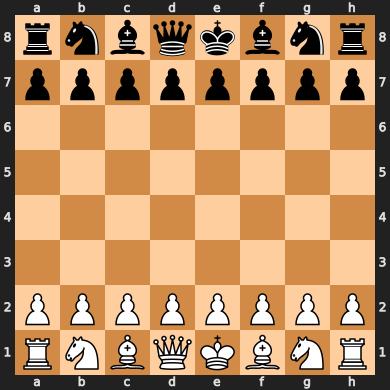

In [ ]:
board

In [ ]:
# Generate a list of all legal moves
legal_moves_list = list(board.legal_moves)

# Optionally, you can convert these moves to their string notation
legal_moves_str_list = [move.uci() for move in legal_moves_list]

# Print the list of legal moves
print(legal_moves_str_list)
print(len(legal_moves_str_list))

In [ ]:
import random

def random_legal_move(board):
    """
    Returns a random legal move for the given board.

    Args:
    board (chess.Board): The current state of the chess board.

    Returns:
    chess.Move: A random legal move.
    """
    legal_moves = list(board.legal_moves)
    legal_moves_str_list = [move.uci() for move in legal_moves]
    if legal_moves_str_list:
        return random.choice(legal_moves_str_list)
    else:
        return None  # No legal moves available

# Example usage:
# board = chess.Board()
# move = random_legal_move(board)
# print(move)


In [ ]:
counter = 0
while True:
    m = random_legal_move(board)
    counter += 1
    if m is None or board.is_game_over():
        print("game has ended", counter)
        print(board.result())
        break
    board.push_san(m)


game has ended 20
1-0


In [ ]:
board.result()

'1-0'

In [ ]:
check_game_over(board)

(True, 'Draw')

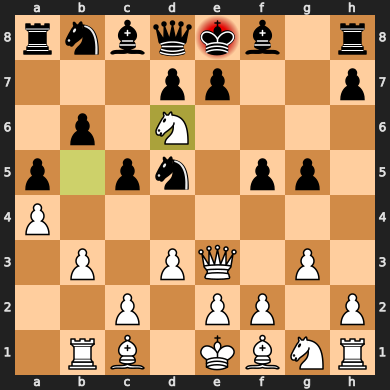

In [ ]:
board